# Diseases Classification

In [2]:
import tensorflow as tf
import os

#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

In [11]:
import tensorflow as tf
import keras
import pandas as pd
from PIL import Image
import PIL
#from keras_preprocessing.image import ImageDataGenerator
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
#from tensorflow.keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import efficientnet.keras as efficientnet
from keras_applications import *
import glob
from sklearn.utils import shuffle
from tensorflow import keras
from PIL import ImageFile

# ensure that truncated images dont throw exception
ImageFile.LOAD_TRUNCATED_IMAGES = True
*

# remove classes with bad performance

In [16]:
df_data = pd.read_csv('./train_data.csv')
df_data_augmented = pd.read_csv('./train_data_augmented.csv')

In [17]:
df_data_augmented = df_data_augmented[~df_data_augmented.label_diseases_summerized.isin(['tomato_leaf_mosaic_virus', 'tomato_leaf_yellow_virus'])]

In [18]:
df_train = df_data[:2200]
df_test = df_data[2200:]

df_train_augemented = df_data_augmented[:10000]
df_test_augemented = df_data_augmented[10000:]

print(df_train.shape, df_test.shape)

print(df_train_augemented.shape, df_test_augemented.shape)

(2200, 4) (457, 4)
(10000, 4) (2185, 4)


In [19]:
# early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [20]:
# ImageDataGenerator to pass data from df into NN
# augmentation parameters in ImageDataGenerator are not nessecary due to manually augmentation of original images
datagen = ImageDataGenerator(rescale=1./255,
#                            horizontal_flip=True, 
#                            rotation_range=20,
#                            shear_range=0.1
                            )

In [21]:
train_generator = datagen.flow_from_dataframe(
    dataframe = df_train_augemented,
    directory = None,
    x_col = 'filename', 
    y_col = 'label_diseases_summerized', 
    class_mode = 'categorical',
    target_size=(224,224), 
    batch_size=32)

Found 9993 validated image filenames belonging to 10 classes.


/home/vlba/anaconda3/envs/env_mv/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [22]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = df_test_augemented,
    directory = None,
    x_col = 'filename', 
    y_col = 'label_diseases_summerized', 
    class_mode = 'categorical',
    target_size=(224,224), 
    batch_size=1)

Found 2182 validated image filenames belonging to 10 classes.


/home/vlba/anaconda3/envs/env_mv/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL=valid_generator.n//valid_generator.batch_size

In [18]:
# use base model and append own classification layers on top
base_model = efficientnet.EfficientNetB0(weights='imagenet', include_top=False,
                                         backend=tf.keras.backend,
                                         layers=tf.keras.layers,
                                         models=tf.keras.models,
                                         utils=tf.keras.utils)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)  
x = Dense(512,activation='relu')(x) 
preds = Dense(len(df_train_augemented['label_diseases_summerized'].value_counts()),activation='softmax')(x) 
model = Model(inputs = base_model.input, outputs = preds)


# train only appended head 
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history1 = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VAL,
    workers=8,
    callbacks=[callback]
)


# train all except first 100 layers
# len(model.layers) = 239
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True
    
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VAL,
    workers=8, 
    callbacks=[callback]
)

/home/vlba/anaconda3/envs/env_mv/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
312/312 [==============================] - 160s 501ms/step - loss: 1.2230 - accuracy: 0.5789 - val_loss: 0.7482 - val_accuracy: 0.7269
Epoch 2/10
312/312 [==============================] - 157s 500ms/step - loss: 0.6104 - accuracy: 0.7843 - val_loss: 0.5498 - val_accuracy: 0.7929
Epoch 3/10
312/312 [==============================] - 156s 499ms/step - loss: 0.4534 - accuracy: 0.8376 - val_loss: 0.5719 - val_accuracy: 0.8020
Epoch 4/10
312/312 [==============================] - 156s 496ms/step - loss: 0.3527 - accuracy: 0.8733 - val_loss: 0.4336 - val_accuracy: 0.8515
Epoch 5/10
312/312 [==============================] - 156s 497ms/step - loss: 0.2764 - accuracy: 0.9041 - val_loss: 0.4034 - val_accuracy: 0.8529
Epoch 6/10
312/312 [==============================] - 157s 500ms/step - loss: 0.2351 - accuracy: 0.9124 - val_loss: 0.4183 - val_accuracy: 0.8593
Epoch 7/10
312/312 [==============================] - 157s 498ms/step - loss: 0.2049 - accuracy: 0.9282 - val_loss: 0.4571 -

In [20]:
model.save('model_diseases_reduced_labels_augmented.h5')

## Evaluation

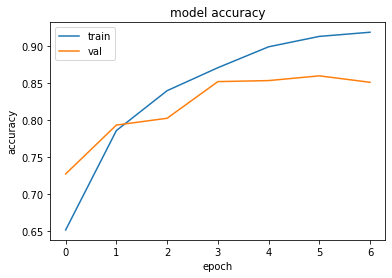

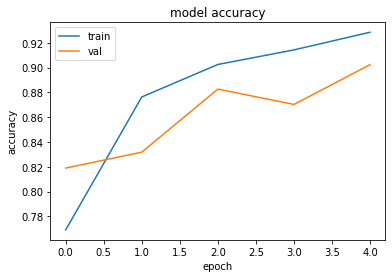

<Figure size 432x288 with 0 Axes>

In [21]:
#plot acc
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('disease_acc_hist1.png')

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('disease_acc_hist2.png')

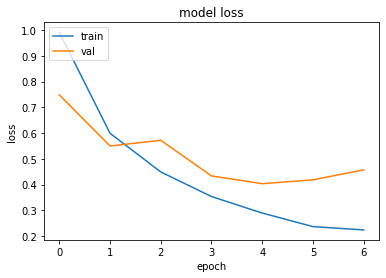

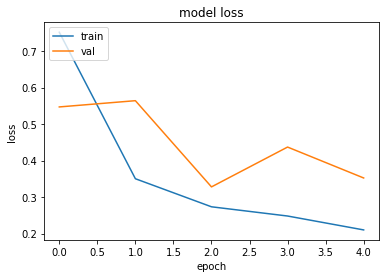

<Figure size 432x288 with 0 Axes>

In [22]:
#plot loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('disease_loss_hist1.png')

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('disease_loss_hist2.png')

In [23]:
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
model = load_model('model_diseases_reduced_labels_augmented.h5')

In [24]:
y_true = []
y_pred = []

label_map = (valid_generator.class_indices)
for index, row in df_test_augemented.iterrows():
    im = Image.open(row["filename"]).convert('RGB') 
    im = im.resize((224,224))
    im = np.asarray(im).astype(float) / 255.
    y_true.append(row['label_diseases_summerized'])
    pred = model.predict(im.reshape((1,)+ (224,224,3)))
    y_pred.append(list(label_map.keys())[list(label_map.values()).index(np.argmax(pred[0]))])

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

print('Classification Report')
print(classification_report(y_true, y_pred))

Confusion Matrix
[[ 42   0   1   0   0   1   2   0   0   0]
 [  0  33   0   0   0   0   1   0   0   0]
 [  0   0 459  20   7   2  23   0   8   2]
 [  0   1  23 339   4   3  33   2  19   3]
 [  1   1   2   9  98   0   5   0  11   0]
 [  0   0   4   0   0  75   0   0   0   0]
 [  0   1   4   8   3   0 500   0   0   0]
 [  0   0   2   1   0   0   0  97   0   0]
 [  0   1  13   7   9   0   1   0 191   6]
 [  0   0   0   1   0   0   0   1   3 102]]
Classification Report
                            precision    recall  f1-score   support

           apple_scab_leaf       0.98      0.91      0.94        46
      grape_leaf_black_rot       0.89      0.97      0.93        34
                   healthy       0.90      0.88      0.89       521
               leaf_blight       0.88      0.79      0.83       427
 peach_leaf_bacterial_spot       0.81      0.77      0.79       127
           peach_leaf_curl       0.93      0.95      0.94        79
                 rust_leaf       0.88      0.97      

In [26]:
from numba import cuda
cuda.select_device(0)
cuda.close()